<a href="https://colab.research.google.com/github/jwang44/Plucking-Style-Detection/blob/main/Exps_on_subset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparation

In [ ]:
!pip install essentia
!pip install pydub

     |████████████████████████████████| 12.0MB 6.7MB/s 


In [ ]:
import numpy as np
import pickle
import glob, os

from collections import Counter
from statistics import stdev
import matplotlib.pyplot as plt  

import essentia
from essentia.standard import *

import xml.etree.ElementTree as ET
from pydub import AudioSegment

## String number estimation using Dataset2

#### Split licks in Dataset 2 into single notes

Dataset 2 contains several versions of 12 realistic guitar phrases. 

We discard the polyphonic ones

In [ ]:
AUDIO_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*.wav'
ANNO_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/annotation'
NOTE_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_string'

LICK7 = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*_Lick7_*.wav'
LICK8 = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*_Lick8_*.wav'
LICK9 = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*_Lick9_*.wav'
LICK10 = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*_Lick10_*.wav'
LICK12 = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*_Lick12_*.wav'

MONO = set(glob.iglob(AUDIO_DIR)) - set(glob.iglob(LICK7)) - set(glob.iglob(LICK8)) - set(glob.iglob(LICK9)) - set(glob.iglob(LICK10)) - set(glob.iglob(LICK12))

# iterate over phrases in dataset2 and split them into single notes with informative file names

for audio_file in MONO:
  print(audio_file)
  audio = AudioSegment.from_wav(audio_file)

  anno_file = os.path.splitext(os.path.basename(audio_file))[0]+'.xml'
  anno_file = os.path.join(ANNO_DIR, anno_file)
  tree = ET.parse(anno_file)
  root = tree.getroot()
  for event in root[1]:
    onset = float(event[0].text)
    pitch = int(event[1].text)
    offset = float(event[2].text)
    excitation_style = event[3].text
    expression_style = event[4].text
    fret = int(event[5].text)
    string = int(event[6].text)
    note_audio = audio[onset*1000:offset*1000]
    note_audio.export(os.path.join(NOTE_DIR, '{}_{}_{}_{}.wav'.format(excitation_style, pitch, string, onset)), format="wav")


In [ ]:
%cd '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_string'
!ls | wc -l

/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_string
2988


#### Feature extraction on single note recordings and save features and labels to pickle

In [ ]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()
spectral_centroid = SpectralCentroidTime()
mfcc = MFCC()

In [ ]:
NOTE_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_string/*.wav'
# iterate over all single notes in dataset2 (split in previous cells)
i=0

data = []
excitation_labels = []
pitch_labels = []
string_labels = []

for audio_file in glob.iglob(NOTE_DIR):
  excitation_label = os.path.basename(audio_file).split('_')[0]
  pitch_label = os.path.basename(audio_file).split('_')[1]
  string_label = os.path.basename(audio_file).split('_')[2]

  audio = MonoLoader(filename=audio_file)()
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
      _, mfcc_coeffs = mfcc(spectrum(w(frame)))
      # add frame-level features to the pool
      pool.add('mfcc', mfcc_coeffs)
  # compute statistics of the features
  aggr_pool = PoolAggregator(defaultStats = ['min', 'max', 'median', 'mean', 'var', 'skew', 'kurt'])(pool)
  # add note-level features
  # centroid = spectral_centroid(audio)
  # pitch = int(pitch_label)
  # f0 = (2 ** ((pitch-69)/12))*440
  # aggr_pool.add('centroid', centroid)
  # aggr_pool.add('f0', f0)

  feature = np.array([])
  for key in aggr_pool.descriptorNames():
    feature = np.concatenate((feature, aggr_pool[key]))
  data.append(feature)

  excitation_labels.append(excitation_label)
  pitch_labels.append(int(pitch_label))
  string_labels.append(int(string_label))

  i+=1
  if i%200==0:
    print(i)


In [ ]:
print(len(data))
print(len(excitation_labels))
print(len(pitch_labels))
print(len(string_labels))

2988
2988
2988
2988


In [ ]:
from collections import Counter
print(Counter(excitation_labels))
print(Counter(pitch_labels))
print(Counter(string_labels))

Counter({'PK': 1478, 'MU': 795, 'FS': 715})
Counter({62: 306, 64: 300, 69: 224, 48: 173, 67: 144, 57: 142, 59: 141, 60: 140, 61: 137, 50: 133, 55: 113, 52: 113, 66: 108, 54: 104, 45: 89, 56: 77, 53: 65, 74: 55, 72: 42, 58: 36, 65: 35, 71: 33, 73: 27, 78: 27, 47: 27, 49: 26, 63: 24, 68: 18, 83: 15, 43: 15, 70: 12, 76: 9, 51: 9, 75: 9, 79: 9, 87: 6, 92: 6, 46: 6, 77: 6, 40: 3, 41: 3, 42: 3, 44: 3, 88: 3, 80: 3, 81: 3, 82: 3, 84: 3})
Counter({4: 771, 5: 599, 2: 562, 3: 527, 6: 322, 1: 207})


In [ ]:
with open('/content/drive/MyDrive/dataset2_pkl_mono/MFCC.pkl', 'wb') as file:
    pickle.dump(data, file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/EXCI_LABEL.pkl', 'wb') as file:
    pickle.dump(excitation_labels, file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/STR_LABEL.pkl', 'wb') as file:
    pickle.dump(string_labels, file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/PITCH_LABEL.pkl', 'wb') as file:
    pickle.dump(pitch_labels, file)

#### Load features and labels

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.utils import shuffle
from statistics import stdev

In [ ]:
with open('/content/drive/MyDrive/dataset2_pkl_mono/MFCC.pkl', 'rb') as file:
    data = pickle.load(file)
with open('/content/drive/MyDrive/dataset2_pkl_mono/STR_LABEL.pkl', 'rb') as file:
    string_labels = pickle.load(file)

In [ ]:
print(Counter(excitation_labels))
print(Counter(pitch_labels))
print(Counter(string_labels))

Counter({'PK': 1478, 'MU': 795, 'FS': 715})
Counter({62: 306, 64: 300, 69: 224, 48: 173, 67: 144, 57: 142, 59: 141, 60: 140, 61: 137, 50: 133, 55: 113, 52: 113, 66: 108, 54: 104, 45: 89, 56: 77, 53: 65, 74: 55, 72: 42, 58: 36, 65: 35, 71: 33, 73: 27, 78: 27, 47: 27, 49: 26, 63: 24, 68: 18, 83: 15, 43: 15, 70: 12, 76: 9, 51: 9, 75: 9, 79: 9, 87: 6, 92: 6, 46: 6, 77: 6, 40: 3, 41: 3, 42: 3, 44: 3, 88: 3, 80: 3, 81: 3, 82: 3, 84: 3})
Counter({4: 771, 5: 599, 2: 562, 3: 527, 6: 322, 1: 207})


In [ ]:
data = np.vstack(data) 
le = LabelEncoder()
string_labels = le.fit_transform(string_labels) # convert category from string to numerical

#### Train monophonic string number classifier

In [ ]:
# split into train and test
X = data
y = string_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model = make_pipeline(StandardScaler(), SVC())
parameters = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'svc__C':[0.2, 1, 5], 
    'svc__gamma': ['scale', 'auto']
    }
clf = GridSearchCV(model, parameters, n_jobs=-1, refit=True, cv=10, return_train_score=True)
clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_

In [ ]:
clf.score(X_test, y_test)

0.9147157190635451

In [ ]:
clf.best_params_

{'svc__C': 5, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

In [ ]:
# Sanity check use normal Kfold
X = X_train
y = y_train
model = make_pipeline(StandardScaler(), SVC(C=5, gamma='scale'))
kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_accus = []
val_accus = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    train_accus.append(model.score(X_train, y_train))
    val_accus.append(model.score(X_val, y_val))
train_accus = np.array(train_accus)
val_accus = np.array(val_accus)
print("-------------Monophonic String Number Classification---------------")
print("train accu: ", train_accus.mean(), "Std dev: ", stdev(train_accus))
print("val accu: ", val_accus.mean(), "Std dev: ", stdev(val_accus))
print("test accu: ", model.score(X_test, y_test))

## Pitch Estimation on Dataset 2

Get a single note audio. 

Use MultiPitch to get a list of arrays (the estimated f0s corresponding to each frame). 

Convert all estimated freqs to midi note number

Round the midi note numbers

Round the estimated frequencies

Convert items in lists from array to tuple, so that they're hashable and can do majority voting

Use majority voting to decide on the final pitch(es) for the single pluck

#### Estimate pitch on dataset2 single notes

In [ ]:
with open('/content/drive/MyDrive/dataset2_pkl_mono/PITCH_LABEL.pkl', 'rb') as file:
    pitch_labels = pickle.load(file)

In [ ]:
AUDIO_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_string/*.wav'
from essentia.standard import MultiPitchKlapuri, PitchMelodia, PitchYin
i=0
correct = 0

for audio_file in glob.iglob(AUDIO_DIR):
  # pitch label in str
  pitch_label = int(pitch_labels[i])
  audio = MonoLoader(filename=audio_file)()
  mp = MultiPitchKlapuri()
  # pitchyin = PitchYin()
  freqs = mp(audio) # this is a list of arrays

  notes = []
  for freq_array in freqs:
    note_array = np.round(12*np.log2(freq_array/440)+69)
    note_tuple = tuple(note_array)
    notes.append(note_tuple)

  pitch_pred = max(set(notes), key=notes.count)
  if pitch_label == pitch_pred[0]:
    correct+=1

  i+=1
  if i%50==0:
    print(i)

print("Pitch Estimation accuracy: ", correct/i)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
Pitch Estimation accuracy:  0.8530789825970548


## Plucking Style classification

#### Split licks in Dataset 2 into single notes

In [ ]:
AUDIO_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/audio/*.wav'
ANNO_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/dataset2/annotation'
NOTE_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_pluck'
# iterate over all files in dataset2 and split them into single notes with informative file names
import glob, os
import xml.etree.ElementTree as ET
from pydub import AudioSegment

for audio_file in glob.iglob(AUDIO_DIR):
  audio = AudioSegment.from_wav(audio_file)

  anno_file = os.path.splitext(os.path.basename(audio_file))[0]+'.xml'
  anno_file = os.path.join(ANNO_DIR, anno_file)
  tree = ET.parse(anno_file)
  root = tree.getroot()
  for event in root[1]:
    onset = float(event[0].text)
    pitch = int(event[1].text)
    offset = float(event[2].text)
    excitation_style = event[3].text
    expression_style = event[4].text
    fret = int(event[5].text)
    string = int(event[6].text)
    note_audio = audio[onset*1000:offset*1000]
    note_audio.export(os.path.join(NOTE_DIR, '{}_{}_{}_{}.wav'.format(excitation_style, pitch, string, onset)), format="wav")


In [ ]:
%cd '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_Renamed'
!ls | wc -l

/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_Renamed
4812


In [ ]:
FS = len(glob.glob1('/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_Renamed', 'FS*'))
PK = len(glob.glob1('/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_Renamed', 'PK*'))
MU = len(glob.glob1('/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_Renamed', 'MU*'))
print('Fingerstyle: ', FS)  # 1309
print('Picked: ', PK) # 2085
print('Muted: ', MU)  # 1397
print('Total: ', FS+PK+MU)  # 4791

Fingerstyle:  1318
Picked:  2090
Muted:  1404
Total:  4812


#### Feature extraction on single note recordings and save features and labels to pickle

In [ ]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()
spectral_centroid = SpectralCentroidTime()
mfcc = MFCC()

In [ ]:
NOTE_DIR = '/content/drive/MyDrive/IDMT-SMT-GUITAR_V2/Notes_pluck/*.wav'
# iterate over all single notes in dataset2 (split in previous cells)
import glob, os
i=0

data = []
excitation_labels = []
pitch_labels = []
string_labels = []

for audio_file in glob.iglob(NOTE_DIR):
  excitation_label = os.path.basename(audio_file).split('_')[0]
  pitch_label = os.path.basename(audio_file).split('_')[1]
  string_label = os.path.basename(audio_file).split('_')[2]

  audio = MonoLoader(filename=audio_file)()
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
      _, mfcc_coeffs = mfcc(spectrum(w(frame)))
      centroid = spectral_centroid(w(frame))

      # add frame-level features to the pool
      pool.add('mfcc', mfcc_coeffs)
      pool.add('spectral_centroid', essentia.array([centroid]))
  # compute statistics of the features
  aggr_pool = PoolAggregator(defaultStats = ['min', 'max', 'median', 'mean', 'var', 'skew', 'kurt'])(pool)
  # add note-level features
  # centroid = spectral_centroid(audio)
  pitch = int(pitch_label)
  f0 = (2 ** ((pitch-69)/12))*440
  # aggr_pool.add('centroid', centroid)
  aggr_pool.add('f0', f0)

  feature = np.array([])
  for key in aggr_pool.descriptorNames():
    feature = np.concatenate((feature, aggr_pool[key]))
  data.append(feature)

  excitation_labels.append(excitation_label)
  pitch_labels.append(int(pitch_label))
  string_labels.append(int(string_label))

  i+=1
  if i%200==0:
    print(i)


In [ ]:
print(len(data))
print(len(excitation_labels))
print(len(pitch_labels))
print(len(string_labels))

4812
4812
4812
4812


In [ ]:
from collections import Counter
print(Counter(excitation_labels))
print(Counter(pitch_labels))
print(Counter(string_labels))

Counter({'PK': 2090, 'MU': 1404, 'FS': 1318})
Counter({64: 440, 62: 387, 59: 345, 48: 302, 52: 300, 57: 289, 61: 260, 69: 250, 50: 240, 54: 229, 55: 219, 60: 184, 45: 167, 67: 162, 56: 137, 66: 117, 47: 97, 53: 83, 49: 80, 74: 55, 58: 54, 40: 47, 72: 42, 43: 42, 65: 35, 71: 33, 73: 27, 78: 27, 63: 24, 68: 18, 83: 15, 41: 12, 70: 12, 51: 9, 75: 9, 76: 9, 79: 9, 46: 6, 77: 6, 87: 6, 92: 6, 80: 3, 81: 3, 82: 3, 84: 3, 88: 3, 42: 3, 44: 3})
Counter({4: 1105, 2: 1008, 3: 996, 5: 800, 6: 465, 1: 438})


In [ ]:
with open('/content/drive/MyDrive/dataset2_pkl/MFCC_CENTROID_F0.pkl', 'wb') as file:
    pickle.dump(data, file)
with open('/content/drive/MyDrive/dataset2_pkl/EXCI_LABEL.pkl', 'wb') as file:
    pickle.dump(excitation_labels, file)
with open('/content/drive/MyDrive/dataset2_pkl/STR_LABEL.pkl', 'wb') as file:
    pickle.dump(string_labels, file)
with open('/content/drive/MyDrive/dataset2_pkl/PITCH_LABEL.pkl', 'wb') as file:
    pickle.dump(pitch_labels, file)

#### Load features and labels

In [ ]:
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.utils import shuffle
from statistics import stdev

In [ ]:
with open('/content/drive/MyDrive/dataset2_pkl/MFCC_CENTROID_F0.pkl', 'rb') as file:
    data = pickle.load(file)
with open('/content/drive/MyDrive/dataset2_pkl/EXCI_LABEL.pkl', 'rb') as file:
    excitation_labels = pickle.load(file)

In [ ]:
print(Counter(excitation_labels))

Counter({'PK': 2090, 'MU': 1404, 'FS': 1318})


In [ ]:
data = np.vstack(data)
le = LabelEncoder()
excitation_labels = le.fit_transform(excitation_labels) 

#### Train plucking style classifier

In [ ]:
# split into train and test
X = data
y = excitation_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model = make_pipeline(StandardScaler(), SVC())
parameters = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'svc__C':[0.2, 1, 5], 
    'svc__gamma': ['scale', 'auto']
    }
clf = GridSearchCV(model, parameters, n_jobs=-1, refit=True, cv=10, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            

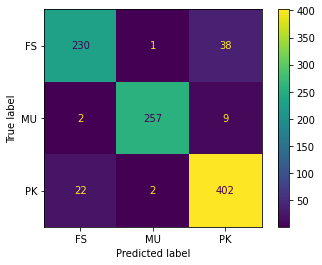

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels=['FS', 'MU', 'PK'], values_format='d')  

In [ ]:
clf.score(X_test, y_test)

0.9231568016614745

In [ ]:
clf.best_params_

{'svc__C': 5, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

In [ ]:
# Sanity check use normal Kfold
X = X_train
y = y_train
model = make_pipeline(StandardScaler(), SVC(C=5, gamma='scale'))
kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_accus = []
val_accus = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    train_accus.append(model.score(X_train, y_train))
    val_accus.append(model.score(X_val, y_val))
train_accus = np.array(train_accus)
val_accus = np.array(val_accus)
print("-------------Plucking Style Classification---------------")
print("train accu: ", train_accus.mean(), "Std dev: ", stdev(train_accus))
print("val accu: ", val_accus.mean(), "Std dev: ", stdev(val_accus))
print("test accu: ", model.score(X_test, y_test))

-------------Plucking Style Classification---------------
train accu:  0.9930429334586377 Std dev:  0.0008215350138467598
val accu:  0.9217978896103896 Std dev:  0.009360659551437455
test accu:  0.9190031152647975
